# 서울시 편의점 매출 결정요인 분석
## 07. 인사이트 도출

---

### 이 노트북의 목표
1. **저평가 지역 발굴**: 예측 매출 > 실제 매출 → 잠재력 있는 지역
2. **고평가 지역 발굴**: 예측 매출 < 실제 매출 → 벤치마킹 대상
3. **신규 출점 추천**: 경쟁 대비 수요가 높은 지역
4. **핵심 인사이트 정리**

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

df = pd.read_csv('./분석데이터.csv', encoding='utf-8-sig')
print(f"데이터: {len(df):,}건")

데이터: 6,097건


## 1. 예측 모델 적합 및 잔차 계산

In [2]:
# 더미변수 생성
df['발달상권'] = (df['주요_상권유형'] == '발달상권').astype(int)
df['전통시장'] = (df['주요_상권유형'] == '전통시장').astype(int)
df['관광특구'] = (df['주요_상권유형'] == '관광특구').astype(int)
df['미분류'] = (df['주요_상권유형'] == '미분류').astype(int)

# 모델 적합
X = df[['점포_수', '총_유동인구_수', '발달상권', '전통시장', '관광특구', '미분류']]
y = df['당월_매출_금액']
X_const = sm.add_constant(X)
model = sm.OLS(y, X_const).fit()

# 예측값 및 잔차 계산
df['예측_매출'] = model.predict(X_const)
df['잔차'] = df['당월_매출_금액'] - df['예측_매출']
df['잔차율'] = df['잔차'] / df['예측_매출'] * 100  # 예측 대비 실제가 몇 % 높은지

print("예측값 및 잔차 계산 완료")
print(f"  잔차 평균: {df['잔차'].mean()/1e8:.2f}억원 (0에 가까우면 정상)")
print(f"  잔차 표준편차: {df['잔차'].std()/1e8:.2f}억원")

예측값 및 잔차 계산 완료
  잔차 평균: -0.00억원 (0에 가까우면 정상)
  잔차 표준편차: 17.88억원


## 2. 저평가 지역 발굴 (잠재력 높은 지역)

**저평가 지역**: 예측 매출 > 실제 매출  
→ 조건(유동인구, 상권유형) 대비 매출이 낮음  
→ 개선 여지 있음 / 신규 진입 기회

In [3]:
# 가장 최근 분기 데이터로 분석
latest_qtr = df['기준_년분기_코드'].max()
df_latest = df[df['기준_년분기_코드'] == latest_qtr].copy()

print(f"분석 기준: {latest_qtr//10}년 {latest_qtr%10}분기")
print(f"행정동 수: {len(df_latest)}개")

분석 기준: 2025년 3분기
행정동 수: 407개


In [4]:
# 저평가 지역 TOP 15 (잔차가 큰 음수 = 예측보다 실제가 낮음)
underperform = df_latest.nsmallest(15, '잔차')[[
    '행정동_코드_명', '주요_상권유형', '점포_수', '총_유동인구_수',
    '당월_매출_금액', '예측_매출', '잔차', '잔차율'
]].copy()

underperform['실제(억)'] = underperform['당월_매출_금액'] / 1e8
underperform['예측(억)'] = underperform['예측_매출'] / 1e8
underperform['차이(억)'] = underperform['잔차'] / 1e8
underperform['유동인구(만)'] = underperform['총_유동인구_수'] / 1e4

print("=" * 70)
print("저평가 지역 TOP 15 (잠재력 높은 지역)")
print("→ 조건 대비 매출이 낮음 = 개선/진입 기회")
print("=" * 70)
print(f"{'행정동':<12} {'상권':<8} {'점포':>4} {'유동인구(만)':>10} {'실제(억)':>8} {'예측(억)':>8} {'차이(억)':>8}")
print("-" * 70)

for _, row in underperform.iterrows():
    print(f"{row['행정동_코드_명']:<12} {row['주요_상권유형']:<8} {row['점포_수']:>4.0f} {row['유동인구(만)']:>10.0f} {row['실제(억)']:>8.1f} {row['예측(억)']:>8.1f} {row['차이(억)']:>+8.1f}")

저평가 지역 TOP 15 (잠재력 높은 지역)
→ 조건 대비 매출이 낮음 = 개선/진입 기회
행정동          상권         점포    유동인구(만)    실제(억)    예측(억)    차이(억)
----------------------------------------------------------------------
강일동          골목상권       14        351      7.9     52.7    -44.8
상봉1동         골목상권       13        476      7.7     51.0    -43.3
신도림동         골목상권       13        648     14.1     54.2    -40.1
공덕동          골목상권        9       1219     11.4     48.9    -37.5
공항동          골목상권       13        541     15.0     52.2    -37.2
연희동          골목상권       14        870     28.8     62.3    -33.5
월계1동         골목상권       13        450     18.2     50.5    -32.3
구로2동         골목상권       10        882     14.5     46.6    -32.1
화곡본동         골목상권       10        821     13.8     45.5    -31.6
신정4동         골목상권       17       1064     46.3     77.9    -31.6
용신동          골목상권       16       1391     50.4     80.0    -29.6
영등포본동        골목상권       11        649     16.7     46.2    -29.5
구의3동         발달상권       13      

## 3. 고평가 지역 발굴 (벤치마킹 대상)

**고평가 지역**: 예측 매출 < 실제 매출  
→ 조건 대비 매출이 높음  
→ 뭔가 잘하고 있음 (벤치마킹 대상)

In [5]:
# 고평가 지역 TOP 15 (잔차가 큰 양수 = 예측보다 실제가 높음)
outperform = df_latest.nlargest(15, '잔차')[[
    '행정동_코드_명', '주요_상권유형', '점포_수', '총_유동인구_수',
    '당월_매출_금액', '예측_매출', '잔차', '잔차율'
]].copy()

outperform['실제(억)'] = outperform['당월_매출_금액'] / 1e8
outperform['예측(억)'] = outperform['예측_매출'] / 1e8
outperform['차이(억)'] = outperform['잔차'] / 1e8
outperform['유동인구(만)'] = outperform['총_유동인구_수'] / 1e4

print("=" * 70)
print("고평가 지역 TOP 15 (벤치마킹 대상)")
print("→ 조건 대비 매출이 높음 = 성공 요인 분석 필요")
print("=" * 70)
print(f"{'행정동':<12} {'상권':<8} {'점포':>4} {'유동인구(만)':>10} {'실제(억)':>8} {'예측(억)':>8} {'차이(억)':>8}")
print("-" * 70)

for _, row in outperform.iterrows():
    print(f"{row['행정동_코드_명']:<12} {row['주요_상권유형']:<8} {row['점포_수']:>4.0f} {row['유동인구(만)']:>10.0f} {row['실제(억)']:>8.1f} {row['예측(억)']:>8.1f} {row['차이(억)']:>+8.1f}")

고평가 지역 TOP 15 (벤치마킹 대상)
→ 조건 대비 매출이 높음 = 성공 요인 분석 필요
행정동          상권         점포    유동인구(만)    실제(억)    예측(억)    차이(억)
----------------------------------------------------------------------
가산동          골목상권       25        502    223.4     99.4   +124.0
역삼1동         골목상권       42       2090    313.6    196.8   +116.8
수서동          발달상권        6        223     92.7     33.1    +59.6
성수2가3동       골목상권        8        585     91.9     33.1    +58.8
서교동          골목상권       41       1733    238.6    186.2    +52.4
명동           발달상권       29        571    183.6    131.4    +52.2
대치4동         발달상권       22       1074    164.6    112.8    +51.8
일원본동         미분류         5        242     69.8     19.1    +50.7
서초2동         골목상권       10        709     84.0     43.4    +40.7
화곡1동         골목상권       12       1647    109.0     68.8    +40.2
자양3동         골목상권        4        644     58.0     18.2    +39.8
오류1동         골목상권        8        420     68.4     30.0    +38.4
신림동          골목상권        6     

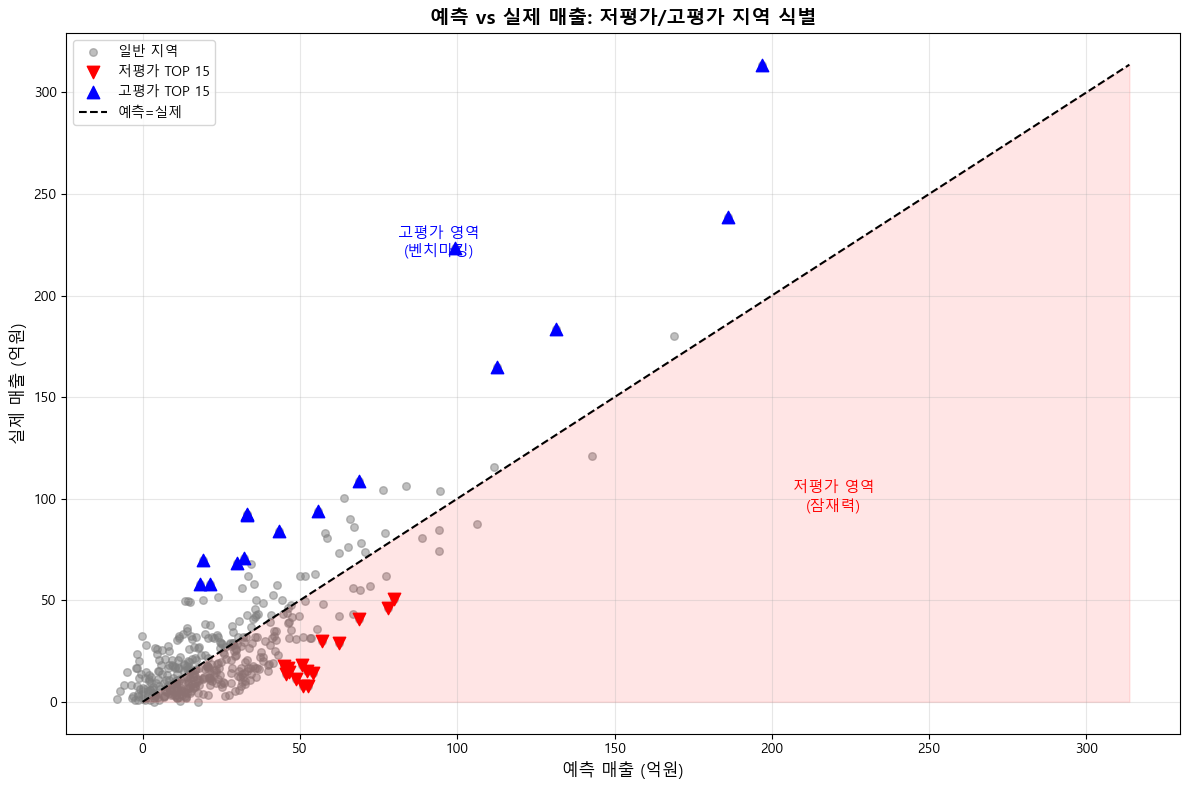

In [6]:
# 시각화: 예측 vs 실제 + 저평가/고평가 표시
fig, ax = plt.subplots(figsize=(12, 8))

# 전체 데이터 산점도
ax.scatter(df_latest['예측_매출']/1e8, df_latest['당월_매출_금액']/1e8, 
           alpha=0.5, s=30, c='gray', label='일반 지역')

# 저평가 지역 (빨간색)
ax.scatter(underperform['예측(억)'], underperform['실제(억)'], 
           c='red', s=80, marker='v', label='저평가 TOP 15', zorder=5)

# 고평가 지역 (파란색)
ax.scatter(outperform['예측(억)'], outperform['실제(억)'], 
           c='blue', s=80, marker='^', label='고평가 TOP 15', zorder=5)

# 완벽한 예측선
max_val = max(df_latest['예측_매출'].max(), df_latest['당월_매출_금액'].max()) / 1e8
ax.plot([0, max_val], [0, max_val], 'k--', linewidth=1.5, label='예측=실제')

ax.set_xlabel('예측 매출 (억원)', fontsize=12)
ax.set_ylabel('실제 매출 (억원)', fontsize=12)
ax.set_title('예측 vs 실제 매출: 저평가/고평가 지역 식별', fontsize=14, fontweight='bold')
ax.legend(loc='upper left')
ax.grid(alpha=0.3)

# 영역 표시
ax.fill_between([0, max_val], [0, max_val], [0, 0], alpha=0.1, color='red', label='')
ax.text(max_val*0.7, max_val*0.3, '저평가 영역\n(잠재력)', fontsize=11, color='red', ha='center')
ax.text(max_val*0.3, max_val*0.7, '고평가 영역\n(벤치마킹)', fontsize=11, color='blue', ha='center')

plt.tight_layout()
plt.savefig('./outputs/11_저평가_고평가_지역.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. 신규 출점 추천 지역

**추천 기준**:  
1. 유동인구 대비 점포수가 적은 지역 (경쟁 덜함)
2. 잠재 수요가 높은 지역

In [7]:
# 점포당 유동인구 계산 (높을수록 경쟁 덜함)
df_latest['점포당_유동인구'] = df_latest['총_유동인구_수'] / df_latest['점포_수'].replace(0, 1)

# 점포당 매출 계산
df_latest['점포당_매출'] = df_latest['당월_매출_금액'] / df_latest['점포_수'].replace(0, 1)

print("[점포당 유동인구 분포]")
print(f"  평균: {df_latest['점포당_유동인구'].mean():,.0f}명")
print(f"  중앙값: {df_latest['점포당_유동인구'].median():,.0f}명")
print(f"  상위 25%: {df_latest['점포당_유동인구'].quantile(0.75):,.0f}명 이상")

[점포당 유동인구 분포]
  평균: 1,418,047명
  중앙값: 973,596명
  상위 25%: 1,627,633명 이상


In [8]:
# 출점 추천 점수 계산
# 점수 = (점포당 유동인구 순위 + 저평가 정도 순위) / 2
df_latest['유동인구_순위'] = df_latest['점포당_유동인구'].rank(ascending=False)
df_latest['저평가_순위'] = df_latest['잔차'].rank(ascending=True)  # 잔차가 작을수록(저평가) 순위 높음
df_latest['추천점수'] = (df_latest['유동인구_순위'] + df_latest['저평가_순위']) / 2

# 상위 15개 추천
recommend = df_latest.nsmallest(15, '추천점수')[[
    '행정동_코드_명', '주요_상권유형', '점포_수', '총_유동인구_수',
    '점포당_유동인구', '당월_매출_금액', '잔차율', '추천점수'
]].copy()

recommend['유동인구(만)'] = recommend['총_유동인구_수'] / 1e4
recommend['점포당유동(만)'] = recommend['점포당_유동인구'] / 1e4
recommend['매출(억)'] = recommend['당월_매출_금액'] / 1e8

print("=" * 75)
print("신규 출점 추천 지역 TOP 15")
print("→ 점포당 유동인구 높고 + 저평가된 지역")
print("=" * 75)
print(f"{'순위':>3} {'행정동':<12} {'상권':<8} {'점포':>4} {'점포당유동(만)':>12} {'매출(억)':>8} {'잔차율':>8}")
print("-" * 75)

for rank, (_, row) in enumerate(recommend.iterrows(), 1):
    print(f"{rank:>3} {row['행정동_코드_명']:<12} {row['주요_상권유형']:<8} {row['점포_수']:>4.0f} {row['점포당유동(만)']:>12.1f} {row['매출(억)']:>8.1f} {row['잔차율']:>+8.1f}%")

신규 출점 추천 지역 TOP 15
→ 점포당 유동인구 높고 + 저평가된 지역
 순위 행정동          상권         점포     점포당유동(만)    매출(억)      잔차율
---------------------------------------------------------------------------
  1 북아현동         골목상권        0       2232.9     12.1    -61.8%
  2 대조동          골목상권        7        179.3     18.9    -54.5%
  3 장위3동         전통시장        2        200.0      0.0   -100.0%
  4 화곡8동         골목상권        6        164.7     10.4    -68.1%
  5 공덕동          골목상권        9        135.5     11.4    -76.7%
  6 삼양동          골목상권        0       1086.5      3.5    -66.2%
  7 중화2동         골목상권        3        259.7      7.2    -56.7%
  8 길음1동         골목상권        3        205.2      1.7    -87.4%
  9 송천동          골목상권        7        145.2     16.2    -56.3%
 10 월곡1동         골목상권        3        267.7      9.6    -44.1%
 11 상계3·4동       골목상권        5        164.0     10.0    -60.8%
 12 황학동          전통시장        1        561.3     12.6    -24.2%
 13 길동           골목상권       12        152.6     56.8    -21.4%


## 5. 상권유형별 효율성 분석

In [9]:
# 상권유형별 점포당 매출
efficiency = df_latest.groupby('주요_상권유형').agg({
    '당월_매출_금액': 'sum',
    '점포_수': 'sum',
    '총_유동인구_수': 'sum',
    '행정동_코드_명': 'count'
}).rename(columns={'행정동_코드_명': '행정동수'})

efficiency['점포당_매출(억)'] = efficiency['당월_매출_금액'] / efficiency['점포_수'] / 1e8
efficiency['점포당_유동인구(만)'] = efficiency['총_유동인구_수'] / efficiency['점포_수'] / 1e4
efficiency['총매출(억)'] = efficiency['당월_매출_금액'] / 1e8

efficiency = efficiency.sort_values('점포당_매출(억)', ascending=False)

print("=" * 70)
print("상권유형별 효율성 분석")
print("=" * 70)
print(f"{'상권유형':<10} {'행정동수':>8} {'총점포':>8} {'점포당매출(억)':>12} {'점포당유동(만)':>12}")
print("-" * 70)

for idx, row in efficiency.iterrows():
    print(f"{idx:<10} {row['행정동수']:>8.0f} {row['점포_수']:>8.0f} {row['점포당_매출(억)']:>12.2f} {row['점포당_유동인구(만)']:>12.1f}")

상권유형별 효율성 분석
상권유형           행정동수      총점포     점포당매출(억)     점포당유동(만)
----------------------------------------------------------------------
전통시장             16       65         6.59        121.5
관광특구              6       83         6.40         44.4
발달상권             20      241         5.52         45.7
미분류              23       82         4.21         75.4
골목상권            342     2049         4.13         94.6


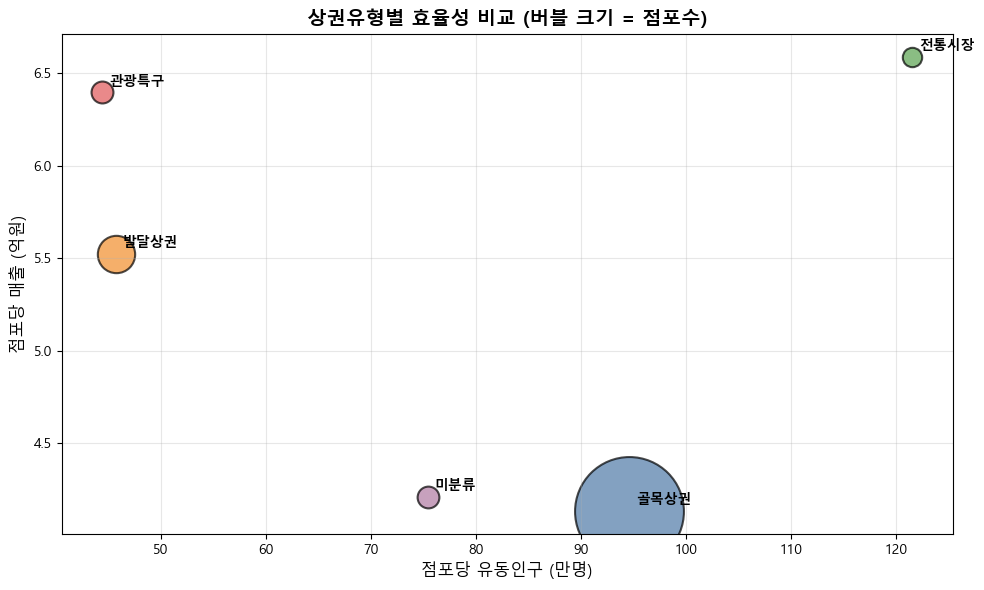

In [10]:
# 시각화: 상권유형별 점포당 매출 vs 점포당 유동인구
fig, ax = plt.subplots(figsize=(10, 6))

colors = {'골목상권': '#4E79A7', '발달상권': '#F28E2B', '전통시장': '#59A14F', 
          '관광특구': '#E15759', '미분류': '#B07AA1'}

for 상권 in efficiency.index:
    row = efficiency.loc[상권]
    ax.scatter(row['점포당_유동인구(만)'], row['점포당_매출(억)'], 
               s=row['점포_수']*3, c=colors.get(상권, 'gray'), 
               alpha=0.7, edgecolor='black', linewidth=1.5, label=상권)
    ax.annotate(상권, (row['점포당_유동인구(만)'], row['점포당_매출(억)']), 
                xytext=(5, 5), textcoords='offset points', fontsize=10, fontweight='bold')

ax.set_xlabel('점포당 유동인구 (만명)', fontsize=12)
ax.set_ylabel('점포당 매출 (억원)', fontsize=12)
ax.set_title('상권유형별 효율성 비교 (버블 크기 = 점포수)', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('./outputs/12_상권유형_효율성.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. 핵심 인사이트 정리

In [11]:
# 저평가 지역 상위 5개
top5_under = underperform.head(5)['행정동_코드_명'].tolist()

# 고평가 지역 상위 5개
top5_out = outperform.head(5)['행정동_코드_명'].tolist()

# 추천 지역 상위 5개
top5_rec = recommend.head(5)['행정동_코드_명'].tolist()

# 효율 최고 상권
best_efficiency = efficiency['점포당_매출(억)'].idxmax()
best_eff_val = efficiency.loc[best_efficiency, '점포당_매출(억)']

print("="*70)
print("핵심 인사이트 정리")
print("="*70)

print(f"""
┌─────────────────────────────────────────────────────────────────────┐
│  1. 저평가 지역 (잠재력 있는 지역)                                   │
├─────────────────────────────────────────────────────────────────────┤
│  조건(유동인구, 상권유형) 대비 매출이 낮은 지역                       │
│  → 운영 개선 또는 신규 진입 시 성장 가능성 높음                       │
│                                                                     │
│  TOP 5: {', '.join(top5_under):<40}│
└─────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────┐
│  2. 고평가 지역 (벤치마킹 대상)                                      │
├─────────────────────────────────────────────────────────────────────┤
│  조건 대비 매출이 높은 지역                                          │
│  → 성공 요인 분석 필요 (입지 외 요인: 운영, 상품구성, 서비스 등)      │
│                                                                     │
│  TOP 5: {', '.join(top5_out):<40}│
└─────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────┐
│  3. 신규 출점 추천 지역                                             │
├─────────────────────────────────────────────────────────────────────┤
│  점포당 유동인구 높고 (경쟁↓) + 저평가 (잠재력↑)                      │
│  → 신규 출점 시 우선 검토 권장                                       │
│                                                                     │
│  TOP 5: {', '.join(top5_rec):<40}│
└─────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────┐
│  4. 상권유형별 효율성                                               │
├─────────────────────────────────────────────────────────────────────┤
│  점포당 매출이 가장 높은 상권: {best_efficiency} ({best_eff_val:.2f}억원)       │
│  → 같은 노력 대비 수익이 가장 높은 상권유형                          │
└─────────────────────────────────────────────────────────────────────┘
""")

핵심 인사이트 정리

┌─────────────────────────────────────────────────────────────────────┐
│  1. 저평가 지역 (잠재력 있는 지역)                                   │
├─────────────────────────────────────────────────────────────────────┤
│  조건(유동인구, 상권유형) 대비 매출이 낮은 지역                       │
│  → 운영 개선 또는 신규 진입 시 성장 가능성 높음                       │
│                                                                     │
│  TOP 5: 강일동, 상봉1동, 신도림동, 공덕동, 공항동               │
└─────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────┐
│  2. 고평가 지역 (벤치마킹 대상)                                      │
├─────────────────────────────────────────────────────────────────────┤
│  조건 대비 매출이 높은 지역                                          │
│  → 성공 요인 분석 필요 (입지 외 요인: 운영, 상품구성, 서비스 등)      │
│                                                                     │
│  TOP 5: 가산동, 역삼1동, 수서동, 성수2가3동, 서교동             │
└───────────────────────────────

## 7. 최종 요약 및 액션 아이템

In [12]:
print("="*70)
print("최종 요약 및 액션 아이템")
print("="*70)

print("""
╔═══════════════════════════════════════════════════════════════════════╗
║                         분석 결과 종합                                ║
╠═══════════════════════════════════════════════════════════════════════╣
║                                                                       ║
║  [연구 질문] 서울시 편의점 매출을 결정하는 핵심 요인은?               ║
║                                                                       ║
║  [답변] 점포수, 유동인구, 상권유형이 핵심 결정요인                    ║
║        - 점포수 1개 증가 → 매출 증가                                  ║
║        - 유동인구 100만명 증가 → 매출 증가                            ║
║        - 발달상권이 골목상권 대비 매출 높음                           ║
║                                                                       ║
╠═══════════════════════════════════════════════════════════════════════╣
║                         액션 아이템                                   ║
╠═══════════════════════════════════════════════════════════════════════╣
║                                                                       ║
║  [신규 출점]                                                          ║
║    1. 추천 지역 TOP 5 우선 검토                                       ║
║    2. 발달상권, 관광특구 입지 우선                                    ║
║    3. 점포당 유동인구 높은 지역 선호                                  ║
║                                                                       ║
║  [기존 점포 개선]                                                     ║
║    1. 저평가 지역 점포 → 운영 점검 (상품, 서비스, 시간대)            ║
║    2. 고평가 지역 점포 → 성공 요인 분석 및 확산                       ║
║                                                                       ║
║  [전략적 제언]                                                        ║
║    1. 유동인구 증가 예상 지역 선점 (개발 예정 지역)                   ║
║    2. 골목상권은 배달/픽업 서비스로 약점 보완                         ║
║    3. 관광특구는 외국인 특화 상품 구비                                ║
║                                                                       ║
╚═══════════════════════════════════════════════════════════════════════╝
""")

최종 요약 및 액션 아이템

╔═══════════════════════════════════════════════════════════════════════╗
║                         분석 결과 종합                                ║
╠═══════════════════════════════════════════════════════════════════════╣
║                                                                       ║
║  [연구 질문] 서울시 편의점 매출을 결정하는 핵심 요인은?               ║
║                                                                       ║
║  [답변] 점포수, 유동인구, 상권유형이 핵심 결정요인                    ║
║        - 점포수 1개 증가 → 매출 증가                                  ║
║        - 유동인구 100만명 증가 → 매출 증가                            ║
║        - 발달상권이 골목상권 대비 매출 높음                           ║
║                                                                       ║
╠═══════════════════════════════════════════════════════════════════════╣
║                         액션 아이템                                   ║
╠═══════════════════════════════════════════════════════════════════════╣
║                                     

In [13]:
# 결과 저장
underperform.to_csv('./outputs/저평가지역_TOP15.csv', encoding='utf-8-sig', index=False)
outperform.to_csv('./outputs/고평가지역_TOP15.csv', encoding='utf-8-sig', index=False)
recommend.to_csv('./outputs/출점추천지역_TOP15.csv', encoding='utf-8-sig', index=False)

print("결과 파일 저장 완료:")
print("  ./outputs/저평가지역_TOP15.csv")
print("  ./outputs/고평가지역_TOP15.csv")
print("  ./outputs/출점추천지역_TOP15.csv")

결과 파일 저장 완료:
  ./outputs/저평가지역_TOP15.csv
  ./outputs/고평가지역_TOP15.csv
  ./outputs/출점추천지역_TOP15.csv


---
## 분석 완료

In [14]:
print("""
╔═════════════════════════════════════════════════════════════════════════╗
║                        전체 노트북 구성                                 ║
╠═════════════════════════════════════════════════════════════════════════╣
║  01_전처리.ipynb   │ 데이터 통합, 변수 생성                            ║
║  02_EDA.ipynb      │ 가설별 탐색적 분석                                ║
║  03_시각화.ipynb   │ 가설별 시각적 검증                                ║
║  04_회귀분석.ipynb │ 가설 통계적 검증                                  ║
║  05_해석.ipynb     │ 결과 해석, 시사점                                 ║
║  06_예측모델.ipynb │ 매출 예측, What-if 시나리오                       ║
║  07_인사이트.ipynb │ 저평가/고평가 지역, 출점 추천 (현재)              ║
╚═════════════════════════════════════════════════════════════════════════╝

분석 완료. 감사합니다.
""")


╔═════════════════════════════════════════════════════════════════════════╗
║                        전체 노트북 구성                                 ║
╠═════════════════════════════════════════════════════════════════════════╣
║  01_전처리.ipynb   │ 데이터 통합, 변수 생성                            ║
║  02_EDA.ipynb      │ 가설별 탐색적 분석                                ║
║  03_시각화.ipynb   │ 가설별 시각적 검증                                ║
║  04_회귀분석.ipynb │ 가설 통계적 검증                                  ║
║  05_해석.ipynb     │ 결과 해석, 시사점                                 ║
║  06_예측모델.ipynb │ 매출 예측, What-if 시나리오                       ║
║  07_인사이트.ipynb │ 저평가/고평가 지역, 출점 추천 (현재)              ║
╚═════════════════════════════════════════════════════════════════════════╝

분석 완료. 감사합니다.

